In [74]:
import pandas as pd
pd.set_option('display.max_colwidth', 500)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as pickle
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

# Loading in the cleaned Data
wBios = pd.read_csv('./Surabhi-1.csv')
wBios = wBios.loc[:, ~wBios.columns.str.contains('^Unnamed')]
UserID = wBios.index
wBios['UserID'] = UserID
noBios = wBios.drop(['Bios'], axis=1)
noBios.head()

,Year,Major_Dept,Ambition,Goals,Music,Sports,Friday_Nights,School_balance,Movie_Genres,Social_Style,Transfer,UserID
0,3,7,1,2,5,5,1,1,9,3,2,0
1,1,8,2,1,1,3,2,2,2,2,1,1
2,1,8,2,2,5,8,1,2,6,3,1,2
3,2,2,2,2,5,6,2,2,5,2,2,3
4,2,6,3,1,8,7,1,1,5,1,1,4


In [75]:
scaler = MinMaxScaler() 
#minmax scaler normalizes the features to be transformed into range of [0,1]
#equation: xScaled = x- xMin divided by xMax - xMin
#more info https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79

noBiosScal = pd.DataFrame(scaler.fit_transform(noBios))
noBiosScal.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.666667,0.857143,0.0,1.0,0.444444,0.444444,0.0,0.0,0.8,1.0,1.0,0.000000
1,0.000000,1.000000,0.5,0.0,0.000000,0.222222,1.0,0.5,0.1,0.5,0.0,0.002571
2,0.000000,1.000000,0.5,1.0,0.444444,0.777778,0.0,0.5,0.5,1.0,0.0,0.005141
3,0.333333,0.142857,0.5,1.0,0.444444,0.555556,1.0,0.5,0.4,0.5,1.0,0.007712
4,0.333333,0.714286,1.0,0.0,0.777778,0.666667,0.0,0.0,0.4,0.0,0.0,0.010283


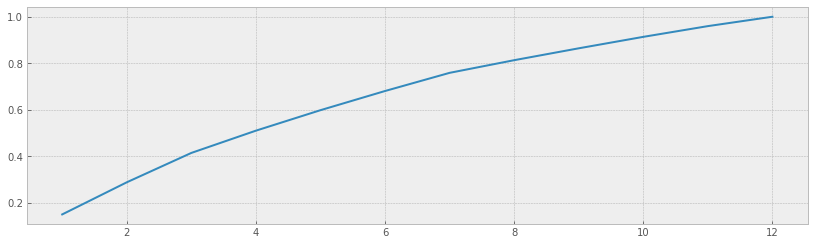

Number features: 10
Total Variance Explained: 0.9596956777223891
0.913574847736433


In [76]:
from sklearn.decomposition import PCA
pca = PCA()

noBios_pca = pca.fit_transform(noBiosScal)

plt.style.use("bmh")
plt.figure(figsize=(14,4))
plt.plot(range(1,noBiosScal.shape[1]+1), pca.explained_variance_ratio_.cumsum())
plt.show()

# Finding the exact number of features that explain at least 95% of the variance in the dataset
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance>=.95])
n_to_reach_95 = noBiosScal.shape[1] - n_over_95

# Printing out the number of features needed to retain 95% variance
print(f"Number features: {n_to_reach_95}\nTotal Variance Explained: {total_explained_variance[n_to_reach_95]}")

# Reducing the dataset to the number of features determined before
pca = PCA(n_components=n_to_reach_95)

# Fitting and transforming the dataset to the stated number of features and creating a new DF
noBios_pca = pca.fit_transform(noBiosScal)

# Seeing the variance ratio that still remains after the dataset has been reduced
print(pca.explained_variance_ratio_.cumsum()[-1])



In [77]:
# Setting the amount of clusters to test out
cluster_cnt = [i for i in range(2, 20, 1)]

# Establishing empty lists to store the scores for the evaluation metrics
s_scores = []

db_scores = []

# Looping through different iterations for the number of clusters
for i in cluster_cnt:
    
    # Hierarchical Agglomerative Clustering with different number of clusters
    hac = AgglomerativeClustering(n_clusters=i)
    
    hac.fit(noBios_pca)
    
    cluster_assignments = hac.labels_
  
    s_scores.append(silhouette_score(noBios_pca, cluster_assignments))
    
    db_scores.append(davies_bouldin_score(noBios_pca, cluster_assignments))

Max Value:
Cluster #    Cluster Score
8       0.178936

Min Value:
Cluster #    Cluster Score
3       0.130305


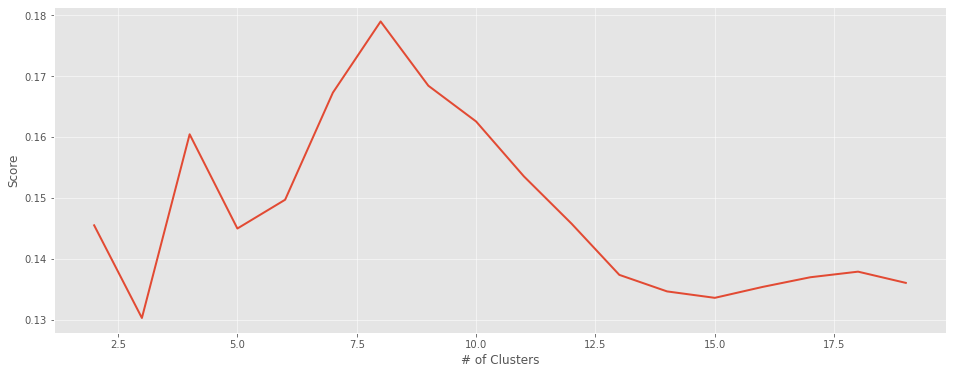

Max Value:
Cluster #    Cluster Score
2       2.375176

Min Value:
Cluster #     Cluster Score
19       1.848412


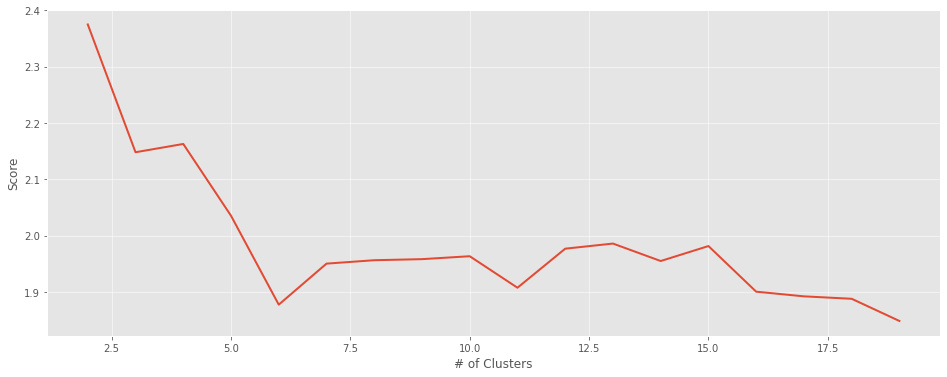

In [78]:
def plot_evaluation(y, x=cluster_cnt):
    """
    Plots the scores of a set evaluation metric. Prints out the max and min values of the evaluation scores.
    """
    
    # Creating a DataFrame for returning the max and min scores for each cluster
    df = pd.DataFrame(columns=['Cluster Score'], index=[i for i in range(2, len(y)+2)])
    df['Cluster Score'] = y
    
    print('Max Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].max()])
    print('\nMin Value:\nCluster #', df[df['Cluster Score']==df['Cluster Score'].min()])
    
    # Plotting out the scores based on cluster count
    plt.figure(figsize=(16,6))
    plt.style.use('ggplot')
    plt.plot(x,y)
    plt.xlabel('# of Clusters')
    plt.ylabel('Score')
    plt.show()
    
# Running the function on the list of scores
plot_evaluation(s_scores)

plot_evaluation(db_scores)

In [79]:
# Instantiating HAC
hac = AgglomerativeClustering(n_clusters=8)

# Fitting
hac.fit(noBios_pca)

# Getting cluster assignments
cluster_assignments = hac.labels_

# Unscaling the categories then replacing the scaled values
noBiosScal = pd.DataFrame(scaler.inverse_transform(noBios))

# Assigning the clusters to each profile
noBios['Cluster #'] = cluster_assignments

# Viewing the dating profiles with cluster assignments
noBios

,Year,Major_Dept,Ambition,Goals,Music,Sports,Friday_Nights,School_balance,Movie_Genres,Social_Style,Transfer,UserID,Cluster #
0,3,7,1,2,5,5,1,1,9,3,2,0,4
1,1,8,2,1,1,3,2,2,2,2,1,1,2
2,1,8,2,2,5,8,1,2,6,3,1,2,6
3,2,2,2,2,5,6,2,2,5,2,2,3,3
4,2,6,3,1,8,7,1,1,5,1,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,3,3,3,2,5,6,1,1,6,3,1,385,6
386,1,5,3,1,7,2,1,1,3,2,2,386,0
387,2,7,1,2,6,6,1,3,6,1,1,387,1
388,2,8,3,1,9,6,1,3,5,2,2,388,0


In [80]:
noBiosClust1 = (noBios[noBios['Cluster #'] == 1])

noBiosClust1.to_csv('./NoBio_Surabhi1_Cluster1.csv')
noBiosClust1.head()

,Year,Major_Dept,Ambition,Goals,Music,Sports,Friday_Nights,School_balance,Movie_Genres,Social_Style,Transfer,UserID,Cluster #
4,2,6,3,1,8,7,1,1,5,1,1,4,1
7,3,6,1,1,5,5,1,3,7,3,1,7,1
20,4,6,3,1,7,9,1,3,11,3,1,20,1
21,1,3,1,1,3,9,1,2,6,1,1,21,1
22,3,1,2,1,3,5,1,2,9,2,1,22,1


In [83]:
wBios= wBios.loc[:, ~wBios.columns.str.contains('^Unnamed')]
wBios.head()

,Bios,Year,Major_Dept,Ambition,Goals,Music,Sports,Friday_Nights,School_balance,Movie_Genres,Social_Style,Transfer,UserID
0,Pop culture maven. Travel advocate. Wannabe coffeeaholic. Proud entrepreneur. Evil internet specialist.,3,7,1,2,5,5,1,1,9,3,2,0
1,Typical internet specialist. Lifelong explorer. Tv trailblazer. General web fan.,1,8,2,1,1,3,2,2,2,2,1,1
2,Thinker. Award-winning web scholar. Unapologetic travel specialist. Professional troublemaker.,1,8,2,2,5,8,1,2,6,3,1,2
3,Hardcore tv advocate. Analyst. Extreme bacon enthusiast. Social media aficionado. Subtly charming alcohol fan.,2,2,2,2,5,6,2,2,5,2,2,3
4,Lifelong alcohol evangelist. Thinker. Food maven. Friendly zombie buff. Web advocate. Falls down a lot.,2,6,3,1,8,7,1,1,5,1,1,4


In [86]:
finalS1 = pd.merge(wBios,noBiosClust1, on='UserID')
finalS1.head()

,Bios,Year_x,Major_Dept_x,Ambition_x,Goals_x,Music_x,Sports_x,Friday_Nights_x,School_balance_x,Movie_Genres_x,...,Ambition_y,Goals_y,Music_y,Sports_y,Friday_Nights_y,School_balance_y,Movie_Genres_y,Social_Style_y,Transfer_y,Cluster #
0,Lifelong alcohol evangelist. Thinker. Food maven. Friendly zombie buff. Web advocate. Falls down a lot.,2,6,3,1,8,7,1,1,5,...,3,1,8,7,1,1,5,1,1,1
1,Professional internet fanatic. Writer. Total alcohol expert. Entrepreneur. Lifelong analyst.,3,6,1,1,5,5,1,3,7,...,1,1,5,5,1,3,7,3,1,1
2,Subtly charming tv expert. Alcohol junkie. Unapologetic zombie enthusiast.,4,6,3,1,7,9,1,3,11,...,3,1,7,9,1,3,11,3,1,1
3,Music aficionado. Devoted reader. Zombie fanatic. Extreme analyst. Subtly charming gamer.,1,3,1,1,3,9,1,2,6,...,1,1,3,9,1,2,6,1,1,1
4,Professional internet fanatic. Writer. Total alcohol expert. Entrepreneur. Lifelong analyst.,3,1,2,1,3,5,1,2,9,...,2,1,3,5,1,2,9,2,1,1


In [44]:
ambition1Clust2 =(noBiosClust2[noBiosClust2['Ambition'] == 1])
ambition1Clust2.head(10)
# ambitionClust2 = noBiosClust2.corrwith(ambition1Clust2)
# ambitionClust2.head()
# corrClust2 = pd.DataFrame(ambitionClust2, columns=['Correlation'])
# corrClust2.head()

,Year,Major_Dept,Ambition,Goals,Music,Sports,Friday_Nights,School_balance,Movie_Genres,Social_Style,Transfer,Cluster #
6,3,8,1,2,3,1,2,1,11,1,1,2
14,4,2,1,2,3,5,2,1,2,1,1,2
36,3,3,1,2,5,3,2,2,8,2,1,2
93,4,1,1,2,10,6,2,2,1,3,1,2
165,3,4,1,2,6,5,2,1,7,3,1,2
175,2,3,1,2,1,7,2,2,3,1,1,2
186,1,7,1,2,9,4,2,1,8,1,1,2
255,3,7,1,2,3,10,2,1,4,1,1,2
263,2,2,1,2,4,7,2,1,9,2,1,2
304,1,5,1,2,7,9,2,2,5,2,1,2


In [41]:
#testing with new cluster amount
# Instantiating HAC
hac = AgglomerativeClustering(n_clusters=20)

# Fitting
hac.fit(noBios_pca)

# Getting cluster assignments
cluster_assignments = hac.labels_

# Unscaling the categories then replacing the scaled values
noBiosScal = pd.DataFrame(scaler.inverse_transform(noBios))

# Assigning the clusters to each profile
noBios['Cluster #'] = cluster_assignments

# Viewing the dating profiles with cluster assignments
noBios

ValueError: operands could not be broadcast together with shapes (675,12) (11,) (675,12) 